In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
from scipy import stats

from pandas.plotting import register_matplotlib_converters
#from statsmodels.tsa.api import Holt

#from acquire import get_store_data, opsd_germany_daily
#import prepare

### Bringing in the CSV's

In [2]:
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

,Date,Price,Open,High,Low,Change %
0,"Dec 04, 2020",6.5301,6.5431,6.5529,6.5268,-0.18%
1,"Dec 03, 2020",6.5418,6.5540,6.5664,6.5423,-0.31%
2,"Dec 02, 2020",6.5622,6.5639,6.5692,6.5519,-0.13%
3,"Dec 01, 2020",6.5705,6.5789,6.5875,6.5606,-0.08%
4,"Nov 30, 2020",6.5760,6.5768,6.5950,6.5708,0.03%


In [3]:
### Only getting a 5 year history

#cny = cny[(cny['date'] > '2015-12-03')]

In [4]:
cny

,Date,Price,Open,High,Low,Change %
0,"Dec 04, 2020",6.5301,6.5431,6.5529,6.5268,-0.18%
1,"Dec 03, 2020",6.5418,6.5540,6.5664,6.5423,-0.31%
2,"Dec 02, 2020",6.5622,6.5639,6.5692,6.5519,-0.13%
3,"Dec 01, 2020",6.5705,6.5789,6.5875,6.5606,-0.08%
4,"Nov 30, 2020",6.5760,6.5768,6.5950,6.5708,0.03%
...,...,...,...,...,...,...
1291,"Dec 11, 2015",6.4553,6.4397,6.4573,6.4397,0.27%
1292,"Dec 10, 2015",6.4378,6.4291,6.4415,6.4290,0.15%
1293,"Dec 09, 2015",6.4280,6.4196,6.4289,6.4184,0.17%
1294,"Dec 08, 2015",6.4172,6.4110,6.4193,6.4110,0.14%


In [5]:
cny.drop(columns = ['Open',
                  'High',
                  'Low',
                   'Change %'], inplace = True)

cny.rename(columns={'Price':'cny_price'}, inplace=True)

In [6]:
cny.Date = pd.to_datetime(cny.Date)
cny

,Date,cny_price
0,2020-12-04,6.5301
1,2020-12-03,6.5418
2,2020-12-02,6.5622
3,2020-12-01,6.5705
4,2020-11-30,6.5760
...,...,...
1291,2015-12-11,6.4553
1292,2015-12-10,6.4378
1293,2015-12-09,6.4280
1294,2015-12-08,6.4172


In [7]:
### Time for some BTC

In [8]:
btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')
btc


,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 06, 2020",19165.0,19157.0,19248.0,19015.6,2.72K,0.04%
1,"Dec 05, 2020",19157.0,18657.0,19157.0,18657.0,3.66K,2.68%
2,"Dec 04, 2020",18657.0,19452.0,19452.0,18657.0,8.65K,-4.06%
3,"Dec 03, 2020",19447.0,19241.0,19560.0,18999.4,5.25K,1.07%
4,"Dec 02, 2020",19241.0,18807.0,19275.0,18538.0,7.63K,2.31%
...,...,...,...,...,...,...,...
1822,"Dec 10, 2015",414.9,418.7,421.0,411.2,21.39K,-0.91%
1823,"Dec 09, 2015",418.7,422.0,426.0,406.5,53.65K,-0.49%
1824,"Dec 08, 2015",420.8,396.7,421.4,388.4,30.42K,6.07%
1825,"Dec 07, 2015",396.7,390.6,403.8,384.9,35.18K,1.56%


In [9]:
### dropping the unncessary columns for the scaler
#btc.Date = pd.to_datetime(btc.Date)

btc.drop(columns = ['Open',
                  'High',
                  'Low',
                    'Vol.',
                   'Change %'], inplace = True)

In [10]:
btc.Date = pd.to_datetime(btc.Date)
btc['Price'].astype(float)
btc

,Date,Price
0,2020-12-06,19165.0
1,2020-12-05,19157.0
2,2020-12-04,18657.0
3,2020-12-03,19447.0
4,2020-12-02,19241.0
...,...,...
1822,2015-12-10,414.9
1823,2015-12-09,418.7
1824,2015-12-08,420.8
1825,2015-12-07,396.7


In [11]:
### Time to merge the DF's together

df = pd.merge(left=btc, right=cny, left_on='Date', right_on='Date')

#df_merge = pd.concat([btc, cny], axis=1)
#df_merge


In [12]:
#df_merge.cny_price.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1295 non-null   datetime64[ns]
 1   Price      1295 non-null   float64       
 2   cny_price  1295 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 40.5 KB


In [13]:
df.drop(columns = ['Date'], inplace = True)

In [14]:
#fliping over the columns to be read from left to right
df = df.iloc[::-1]

In [15]:
scaler = scaler = sklearn.preprocessing.MinMaxScaler()

In [16]:
scaler.fit(df)
#scaler.fit(cny)

df_scaled = scaler.transform(df)
#btc_scaled = scaler.transform(btc)

In [17]:
df_s = pd.DataFrame(df_scaled)

In [18]:
df_s

,0,1
0,0.001956,0.152984
1,0.003203,0.162875
2,0.003094,0.174744
3,0.002897,0.185515
4,0.005040,0.204748
...,...,...
1290,1.000000,0.337400
1291,0.954520,0.331355
1292,0.976975,0.322233
1293,0.987634,0.299813


In [19]:
### need to flip the columns

#df_s = df_s.iloc[::-1]

In [20]:
#df_s

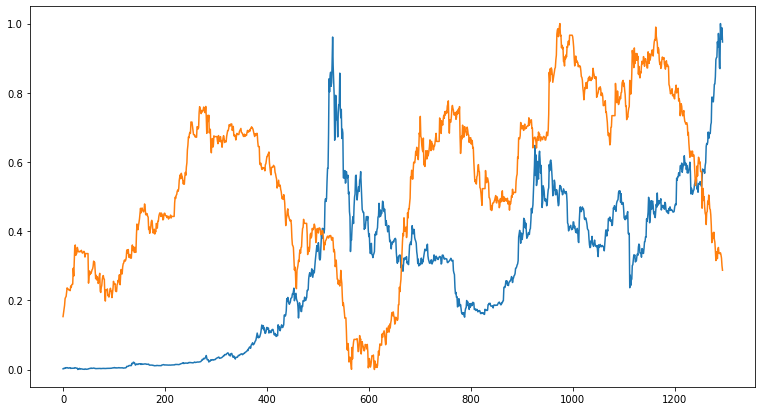

In [21]:
plt.plot(df_s)

# FB Prophet

In [22]:
### bringing in fresh csv's
cny = pd.read_csv('USD_CNY.csv',sep=',', skipinitialspace=True)
cny.head()

cny.drop(columns = ['Open',
                  'High',
                  'Low',
                   'Change %'], inplace = True)

cny.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

cny.ds = pd.to_datetime(cny.ds)

In [24]:
cny = cny.iloc[::-1]

In [25]:
cny

,ds,y
1295,2015-12-07,6.4082
1294,2015-12-08,6.4172
1293,2015-12-09,6.4280
1292,2015-12-10,6.4378
1291,2015-12-11,6.4553
...,...,...
4,2020-11-30,6.5760
3,2020-12-01,6.5705
2,2020-12-02,6.5622
1,2020-12-03,6.5418


In [28]:
m = Prophet()
m.fit(cny)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1656,2021-11-30
1657,2021-12-01
1658,2021-12-02
1659,2021-12-03
1660,2021-12-04


In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1656,2021-11-30,6.204494,3.729268,8.494950
1657,2021-12-01,6.202424,3.756254,8.487340
1658,2021-12-02,6.201164,3.725832,8.505310
1659,2021-12-03,6.200784,3.712675,8.479371
1660,2021-12-04,6.092663,3.594921,8.406446


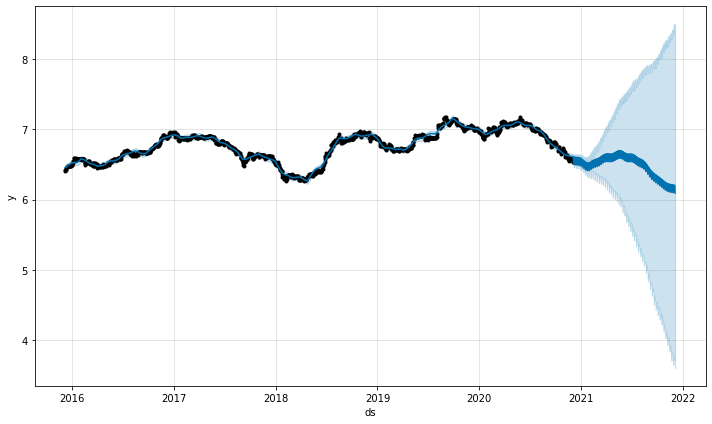

In [31]:
fig1 = m.plot(forecast)

In [26]:
btc = pd.read_csv('BTC_USD.csv',sep=',', skipinitialspace=True, thousands=',')

btc.drop(columns = ['Open',
                  'High',
                  'Low',
                    'Vol.',
                   'Change %'], inplace = True)

btc.Date = pd.to_datetime(btc.Date)
btc['Price'].astype(float)

btc.rename(columns={'Date':'ds','Price':'y'}, inplace=True)

btc = btc.iloc[::-1]

In [27]:
btc

,ds,y
1826,2015-12-06,390.6
1825,2015-12-07,396.7
1824,2015-12-08,420.8
1823,2015-12-09,418.7
1822,2015-12-10,414.9
...,...,...
4,2020-12-02,19241.0
3,2020-12-03,19447.0
2,2020-12-04,18657.0
1,2020-12-05,19157.0


In [32]:
m0 = Prophet()
m0.fit(btc)

future0 = m0.make_future_dataframe(periods=365)
future0.tail()

forecast0 = m0.predict(future)
forecast0[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1656,2021-11-30,21840.111618,11217.945802,32105.187639
1657,2021-12-01,21901.082824,11490.180955,32350.739036
1658,2021-12-02,21931.718225,11629.032447,32247.393419
1659,2021-12-03,21995.455929,11139.513194,32027.050618
1660,2021-12-04,22054.780190,11491.086060,32593.115715


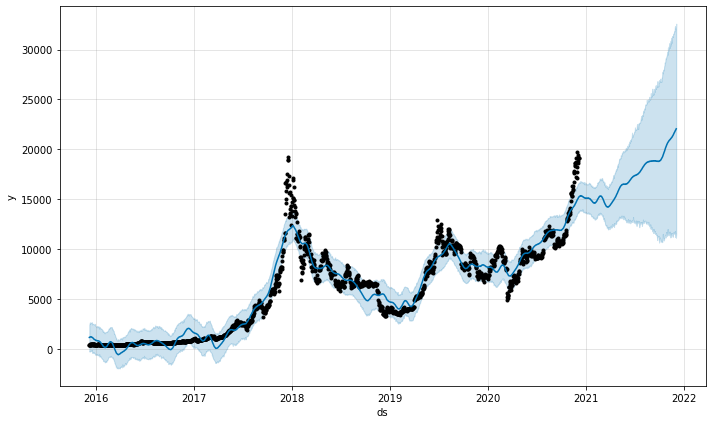

In [33]:
fig2 = m0.plot(forecast0)